In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn
from scipy.spatial.distance import cdist, pdist
import lnbin
import powerlaw
import aicnew
import os, re, sys
%matplotlib inline

In [2]:
df = pd.read_pickle('df.pik')
df.columns

Index([u'subj_id', u'trial_num', u'num_stars', u'clustering', u'totalScore',
       u'mean', u'dev', u'angle_mean', u'angle_dev', u'seg_mean', u'seg_dev',
       u'efficiency', u'seg_efficiency', u'hi', u'midpts', u'freq',
       u'clicks_orig_num_paths', u'clicks_pruned_num_paths', u'seg_midpts',
       u'seg_freq', u'orig_num_paths', u'pruned_num_paths', u'claus_mu',
       u'aic', u'aic_clicks', u'af', u'boxSeries'],
      dtype='object')

In [6]:
df.head()

,subj_id,trial_num,num_stars,clustering,totalScore,mean,dev,angle_mean,angle_dev,seg_mean,...,clicks_pruned_num_paths,seg_midpts,seg_freq,orig_num_paths,pruned_num_paths,claus_mu,aic,aic_clicks,af,boxSeries
0,205189,1,100,1,3,167.871942,140.890006,27.537172,32.253910,265.598856,...,300,"[3.69456906791, 6.82499607234, 12.6078496656, ...","[0.0, 0.0, 0.000676753710402, 0.00219807891334...",188,188,1.639167,lognormal,lognormal,"[1.00176014222, 1.0035249549, 1.00539021042, 0...","[1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ..."
1,224476,1,100,1,56,56.773523,119.893350,30.713535,32.811058,74.596116,...,300,"[3.65441037819, 6.60485036462, 11.9373698694, ...","[0.00207115865295, 0.00229191071966, 0.0057064...",220,220,2.547678,lognormal,lognormal,"[1.00176014222, 1.00185241331, 1.00539021042, ...","[1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ..."
2,503985,1,100,1,49,50.292102,55.291494,44.989178,47.838394,64.458229,...,300,"[3.56499391922, 6.13179202767, 10.5466865646, ...","[0.0, 0.00265232021444, 0.0131073910932, 0.019...",224,224,2.362616,lognormal,lognormal,"[1.00176014222, 1.00185241331, 1.00371176266, ...","[1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ..."
3,539569,1,100,1,59,85.646711,99.711900,26.724675,31.376190,133.289195,...,300,"[3.62727652773, 6.45881779081, 11.5007297999, ...","[0.0, 0.00140777442865, 0.00711546381412, 0.01...",188,188,1.811242,boundedpl,lognormal,"[1.00009054198, 1.01021512127, 1.01042555371, ...","[1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ..."
4,608015,1,100,1,0,94.015794,107.279217,25.339579,32.677060,159.470498,...,300,"[3.64666565387, 6.56294668432, 11.8114116482, ...","[0.0, 0.00145230052557, 0.00322785157366, 0.00...",176,176,1.799232,lognormal,lognormal,"[1.00176014222, 1.00185241331, 0.996158747721,...","[1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, ..."


In [19]:
if not os.path.exists('plots'):
    os.mkdir('plots')

## Scatter plots 

In [3]:
def lnbin_scatter_plot(df, x_name, y_name, xmin=None, m_size=4.0):
    '''
        Input:
            df -> dataframe which contains the data to be plotted
            x_name -> the name of the column to plot along x
            y_name -> the name of the column to plot along y
        Returns:
            fig -> the matplotlib fig object containing the plot
         
        Creates a 3x3 scatter plot across num_stars and clustering.
        columns[xname, yname] will be flattened and plotted for each condition.
    '''
    #puts each "condition" in a list that can be easily iterated through as needed
    num_stars = [100, 600, 1100]
    clustering = [1, 3, 5]

    datas = []
    for n_stars in num_stars:
        for cluster in clustering:
            datas.append(df[ (df['num_stars'] == n_stars) & (df['clustering'] == cluster) ]) 

    #path lengths with raw data
    seaborn.set(context='talk', style='white')
    fig = plt.figure(None, (12,12), dpi=200)
    slopes = []
    for i, data in enumerate(datas):
        mids = np.array(data[x_name])
        freqs = np.array(data[y_name])
        mids = np.array([item for rows in mids for item in rows[0:]])
        freqs = np.array([item for rows in freqs for item in rows[0:]])
        
        #filter out values less than xmin
        if xmin:
            filter_mids = []
            filter_freqs = []
            for x in range(freqs.shape[0]):
                if mids[x] >= xmin:
                    filter_freqs.append(freqs[x])
                    filter_mids.append(mids[x])
            mids = np.array(filter_mids)
            freqs = np.array(filter_freqs)
        
        
        
        indices = np.nonzero(freqs)

        ax = plt.subplot(3,3,i+1)
        plt.loglog(mids[indices], freqs[indices], '.', markersize=m_size)
        plt.ylim(10**-6, 10**-1)
        if i%3 == 0:
            if i == 3:
                plt.ylabel('Frequency(Path Length)', fontsize=20)
                plt.yticks(fontsize=16)
            else:
                ax.set_yticklabels([])
        else:
            ax.set_yticklabels([])
        if i >= 6:
            if i == 7:
                plt.xlabel('Path Length', fontsize=18)
                plt.xticks(fontsize=16)
            else:
                ax.set_xticklabels([])
        else:
            ax.set_xticklabels([])

    for i, label in enumerate(['Most', 'Medium', 'Random']):   
        plt.subplot(3,3,i+1)
        plt.title(label, fontsize=18)

    for num in [(3,100), (6,600), (9, 1100)]:
        ax = plt.subplot(3,3,num[0])
        ax.yaxis.set_label_position("right")
        plt.ylabel(num[1], rotation=-90, labelpad=16, fontsize=18)

    plt.subplots_adjust(hspace = 0.06, wspace = 0.06)

    return fig

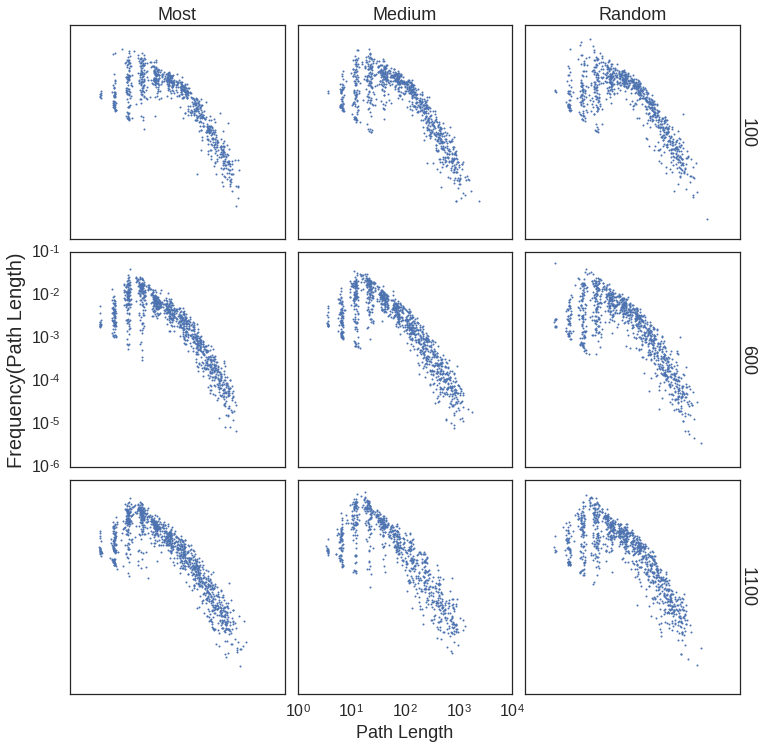

In [4]:
lnbin_scatter_plot(df, 'seg_midpts', 'seg_freq')
plt.savefig(os.path.join('plots', 'scatter.png'))

### Earlier work indicated that a cutoff around 42 was reasonable to elminate noise from sources like the minimum mouse movement people can easily make

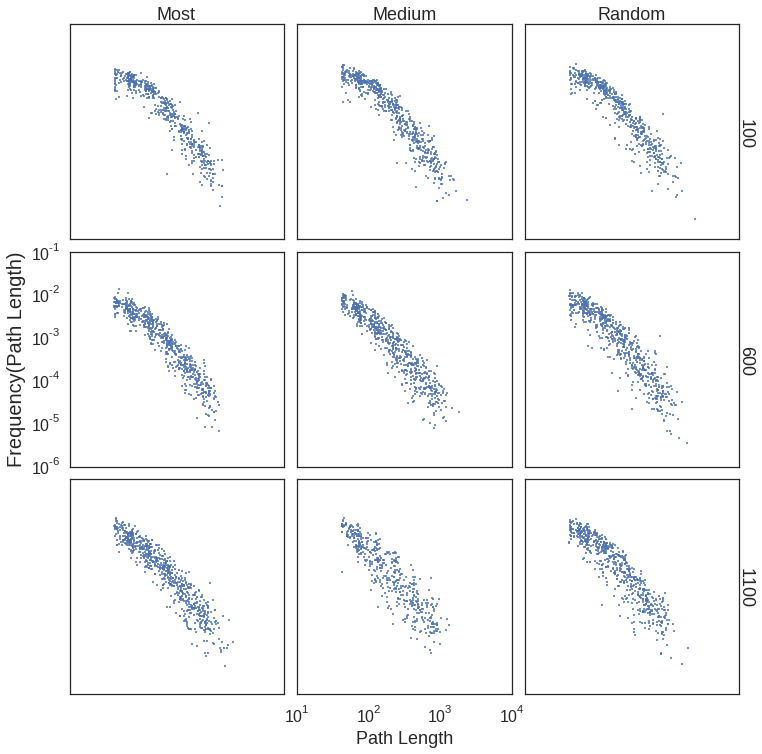

In [21]:
# with xmin cutoff
lnbin_scatter_plot(df, 'seg_midpts', 'seg_freq', 42)
plt.savefig(os.path.join('plots', 'scatter_xmin42.png'))

## Plot interaction between slope and score

### Plot across degrees of clustering

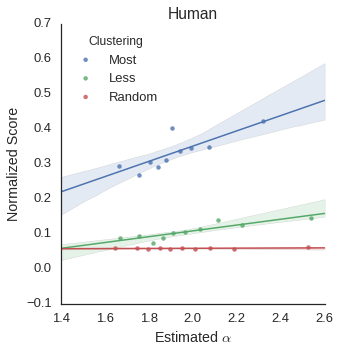

In [5]:
# Generates a plot using evenly sized bins

seaborn.set_context('talk', rc={"lines.linewidth": 1})
seaborn.set_style('white')
dic = {'Slope':[], 'Score':[], 'Clustering':[]}
num_bins = 10 
fig = plt.figure(9, (6, 6))
for i, (clustering, clust_label) in enumerate([(1, 'Most'), (3, 'Less'), (5, 'Random')]):
    dat  = df[df['clustering'] == clustering]
    
    bins = [] # a list of data frames
    data_s = dat.sort_values('claus_mu')
    data_s['norm_score'] = data_s['totalScore'] / data_s['num_stars'].astype(float)
    num_bin_items = int(data_s.shape[0] / num_bins)
    # add items to each bin
    for j in range(num_bins):
        bins.append( data_s.iloc[num_bin_items*j:num_bin_items*(j+1)] )
    # add the leftover items
    if num_bin_items * num_bins < data_s.shape[0]:
        bins[num_bins-1] = bins[num_bins-1].append(data_s.iloc[num_bin_items*num_bins:])
    for binn in bins:
        dic['Slope'].append(binn['claus_mu'].mean())
        dic['Score'].append(binn['norm_score'].mean())
        dic['Clustering'].append(clust_label)
temp_df = DataFrame(dic)

facetgrid = seaborn.lmplot('Slope', 'Score', temp_df, hue='Clustering', legend_out=False, )
plt.xlabel(r'Estimated $\alpha$')
plt.ylabel('Normalized Score')
#plt.ylim(0, 0.3)

plt.title('Human')
facetgrid.add_legend(label_order=['Most', 'Less', 'Random'])

#plt.savefig(os.path.join('plots', 'clauset_slope_vs_score_summary_w_fits.png'), dpi=200)

### Plot across resource density

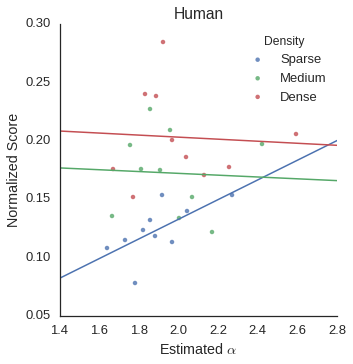

In [35]:
seaborn.set_context('talk', rc={"lines.linewidth": 1})
seaborn.set_style('white')
dic = {'Slope':[], 'Score':[], 'Density':[]}
num_bins = 10
fig = plt.figure(9, (6, 6))
for i, (num_stars, stars_label) in enumerate([(100,'Sparse') , (600, 'Medium'), (1100, 'Dense')]):
    dat  = df[df['num_stars'] == num_stars]
    
    bins = [] # a list of data frames
    data_s = dat.sort_values('claus_mu')
    data_s['norm_score'] = data_s['totalScore'] / data_s['num_stars'].astype(float)
    num_bin_items = int(data_s.shape[0] / num_bins)
    # add items to each bin
    for j in range(num_bins):
        bins.append( data_s.iloc[num_bin_items*j:num_bin_items*(j+1)] )
    # add leftover items
    if num_bin_items * num_bins < data_s.shape[0]:
        bins[num_bins-1] = bins[num_bins-1].append(data_s.iloc[num_bin_items*num_bins:])
    for binn in bins:
        dic['Slope'].append(binn['claus_mu'].mean())
        dic['Score'].append(binn['norm_score'].mean())
        dic['Density'].append(stars_label)
temp_df = DataFrame(dic)
ax = seaborn.lmplot('Slope', 'Score', temp_df, hue='Density', legend_out=False, ci=None)
plt.xlabel(r'Estimated $\alpha$')
plt.ylabel('Normalized Score')
#plt.ylim(0, 0.3)
plt.title('Human')

#plt.savefig('os.path.join('plots', 'slope_vs_score_resources.png'), dpi=200)


### There appears to be no significant pattern in the sparsity, failing to replicate an effect from experiment 2

## Stats 

In [ ]:
import rpy2
%load_ext rpy2.ipython

In [3]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [8]:
df['norm_score'] = df['totalScore'] / df['num_stars'].astype(float)
df_r = df[['subj_id', 'num_stars', 'clustering', 'norm_score', 'claus_mu']].copy()

In [45]:
%R -i df_r

%R library(lme4)

%R df_r$subj_id = factor(df_r$subj_id)
%R df_r$num_stars = factor(df_r$num_stars)
%R df_r$clustering = factor(df_r$clustering)

[1, 1, 1, 1, 1, ..., 5, 5, 5, 5, 5]
Length: 1033
Categories (3, object): [1, 3, 5]

In [46]:
%R anova(lm(norm_score ~ num_stars * clustering, df_r))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
num_stars,2,1.036713,0.518356,24.136797,5.716167e-11
clustering,2,14.682928,7.341464,341.848664,1.901944e-114
num_stars:clustering,4,0.522868,0.130717,6.086714,7.678852e-05
Residuals,1024,21.991191,0.021476,NaN,NaN


In [47]:
%R anova(lm(claus_mu ~ num_stars * clustering, df_r))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
num_stars,2,2.011748,1.005874,18.892498,8.766914e-09
clustering,2,1.103343,0.551671,10.361585,3.507115e-05
num_stars:clustering,4,0.399228,0.099807,1.874594,1.126681e-01
Residuals,1024,54.519800,0.053242,NaN,NaN


### Basic inferential statistics confirm the findings in the visualizations